In [23]:
import sys

import darkdetect
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
from matplotlib import pyplot as plt

from capacitor.generate_mesh import generate_mesh
from capacitor.region import Region
from examples.gen_unit_square import gen_unit_square
from fem.matrix.load_vector import load_node
from fem.matrix.stiffness_matrix import stiffness_node
from fem.mesh.mesh_2d import make_mesh
from fem.plot.plot_mesh import plot_mesh
from fem.plot.plot_pot import plot_pot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
## matplotlib settings
if darkdetect.isDark():
    plt.style.use('dark_background')
else:
    plt.style.use('default')

plt.rcParams.update({
    "text.usetex": True
})

## Setup problem
### 1) Mesh generation

In [25]:
d = 8   # Distance between capacitor plates
l = 10  # Length of capacitor plates
h = 0   # Height of capacitor plates
r = 15  # Radius of circular domain

In [26]:
sys.argv.append('-nopopup')
generate_mesh(d, l, h, r)
msh = make_mesh()

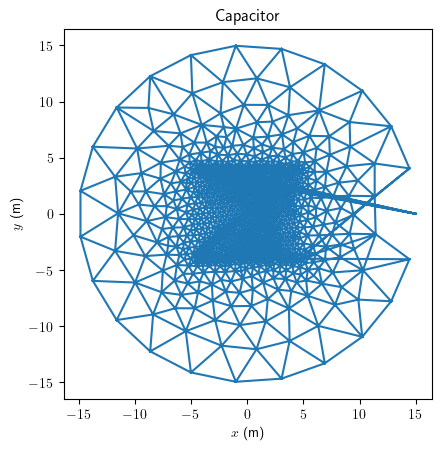

In [27]:
plot_mesh(msh, title='Capacitor')

### 2) Right hand side

In [28]:
b = load_node(msh, lambda p: 0, 3)

### 3) Matrix assembly

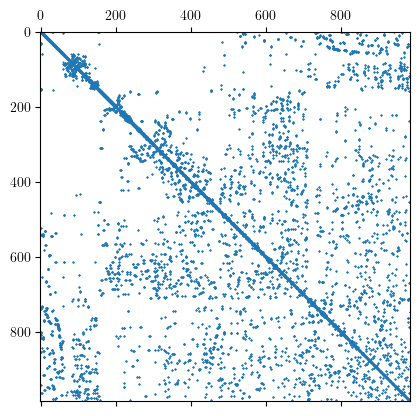

In [29]:
K = stiffness_node(msh)
plt.figure()
plt.spy(K, markersize=.5)

## Boundary conditions

### 1) BC function $g$

In [30]:
import gmsh
mesh = gmsh.model.mesh


V0 = 0
V1 = 1

idx_bc_0 = mesh.get_nodes_for_physical_group(1, Region.PLATE_1)[0] - 1
idx_bc_1 = mesh.get_nodes_for_physical_group(1, Region.PLATE_2)[0] - 1

idx_bc = np.union1d(idx_bc_0, idx_bc_1)
idx_dof = np.setdiff1d(np.arange(msh.N), idx_bc)
u_bc = np.empty((idx_bc.size,))
u_bc[idx_bc_0] = V0
u_bc[idx_bc_1] = V1

### 2) Inflate system

In [31]:
K = K.tocsr()
b = b[idx_dof] - K[idx_dof,:][:,idx_bc] @ u_bc
K = K[idx_dof,:][:,idx_dof]

## Solution
### 1) Solve system

In [32]:
u_h = np.empty((msh.N,))
u_h[idx_bc] = u_bc
u_h[idx_dof], info = sp.linalg.gmres(K, b)
print(f"gmres terminated with exit code {info}")

gmres terminated with exit code 0


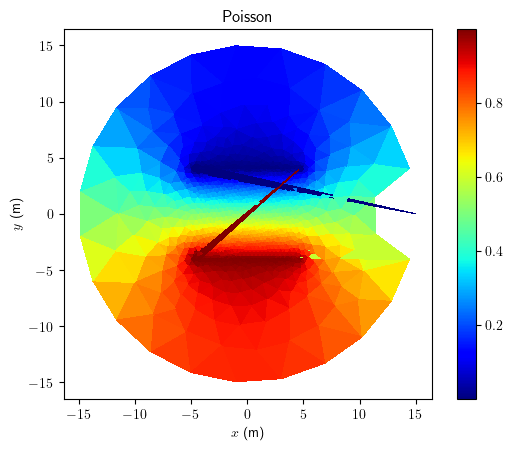

In [33]:
plot_pot(msh, u_h, title=r'Poisson', cmap='jet')